In [1]:
import gumbi as gmb
import torch
from gumbi.regression.botorch import GP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
cars = sns.load_dataset('mpg').dropna().astype({'weight':float, 'model_year':float})

ds = gmb.DataSet(cars,
                 outputs=['mpg', 'acceleration'],
                 log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'])

# Single-output regression

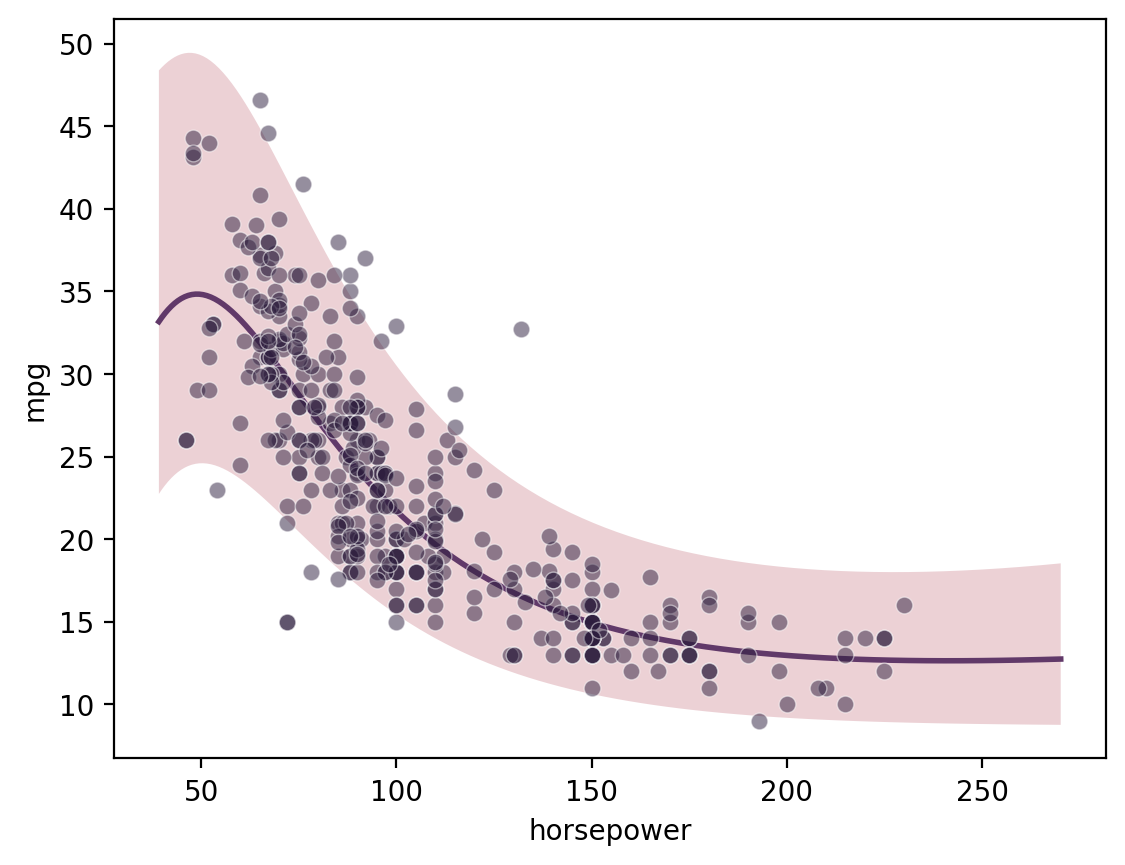

In [3]:
gp = GP(ds)
gp.fit(outputs=['mpg'], continuous_dims=['horsepower'], continuous_kernel='RBF', seed=0, ARD=True)

X = gp.prepare_grid()
y = gp.predict_grid();

pp = gmb.ParrayPlotter(X, y)
pp.plot()
sns.scatterplot(data=cars, x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.5);

## Batch single-task proposals with qNEI

Botorch uses "q Noisy Expected Improvement" (qNEI) to select a batch of points to evaluate. This is now controlled through a simple method `propose`, which _maximizes_ the output by default. Set `maximize=False` to minimize instead.

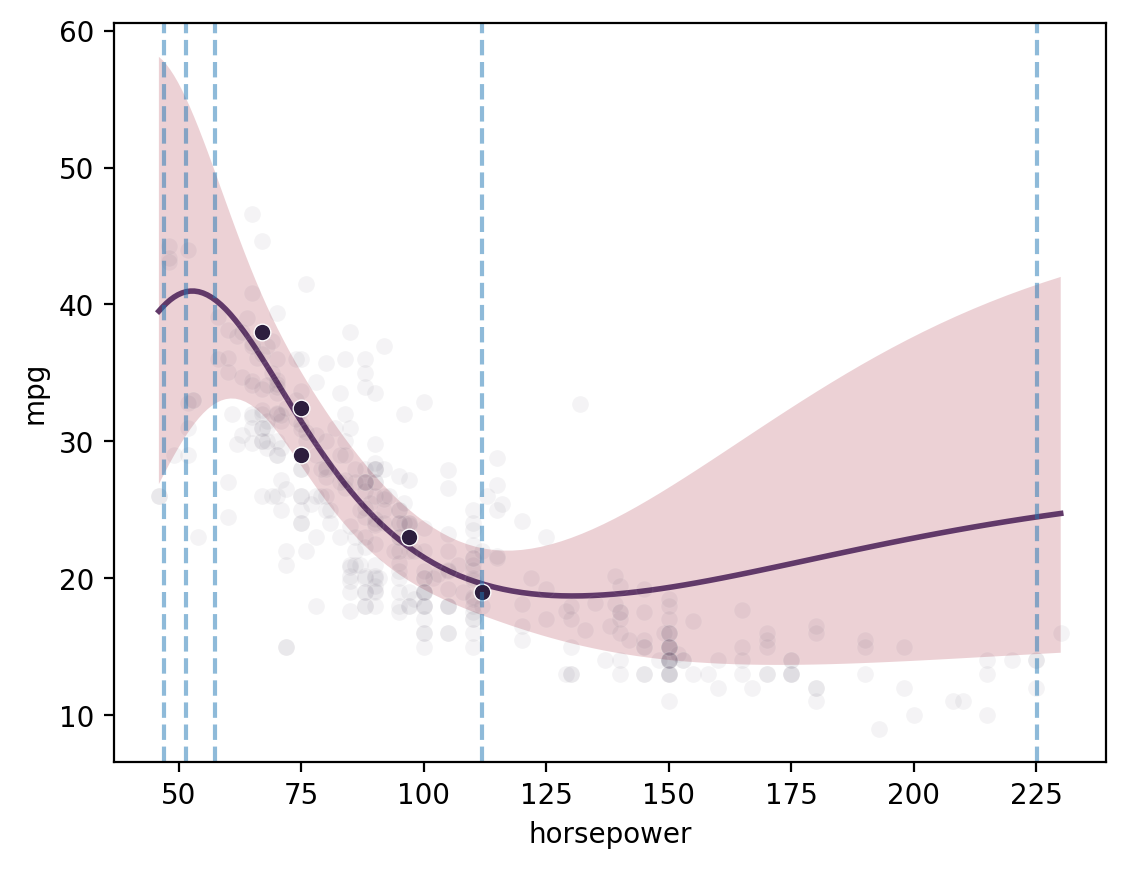

In [11]:
ds2 = gmb.DataSet(
    cars.sample(5, random_state=1),
    outputs=["mpg", "acceleration"],
    log_vars=["mpg", "acceleration", "weight", "horsepower", "displacement"],
)

gp = GP(ds2)
gp.fit(
    outputs=["mpg"],
    continuous_dims=["horsepower"],
    continuous_kernel="RBF",
    seed=0,
    ARD=True,
)

X = gp.prepare_grid(
    limits=gmb.parray(
        horsepower=[ds.wide.horsepower.min(), ds.wide.horsepower.max()], stdzr=gp.stdzr
    )
)
y = gp.predict_grid()

sns.scatterplot(data=cars, x='horsepower', y='mpg', color=sns.cubehelix_palette()[-1], alpha=0.05);
pp = gmb.ParrayPlotter(X, y)
pp.plot()
sns.scatterplot(
    data=ds2.wide, x="horsepower", y="mpg", color=sns.cubehelix_palette()[-1]
)

bounds = np.array([[X.z.values().min(0)+0.1, X.z.values().max(0)-0.1]]).T
bounds = torch.from_numpy(bounds).to(gp.device)

candidates, _ = gp.propose(maximize=True, q=5, bounds=bounds)

for x in candidates:
    plt.axvline(x.values(), color='C0', linestyle='--', alpha=0.5)

# Multi-output regression

/home/mambaforge/envs/sbdb-main/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1724788960438/work/torch/csrc/utils/tensor_new.cpp:641.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


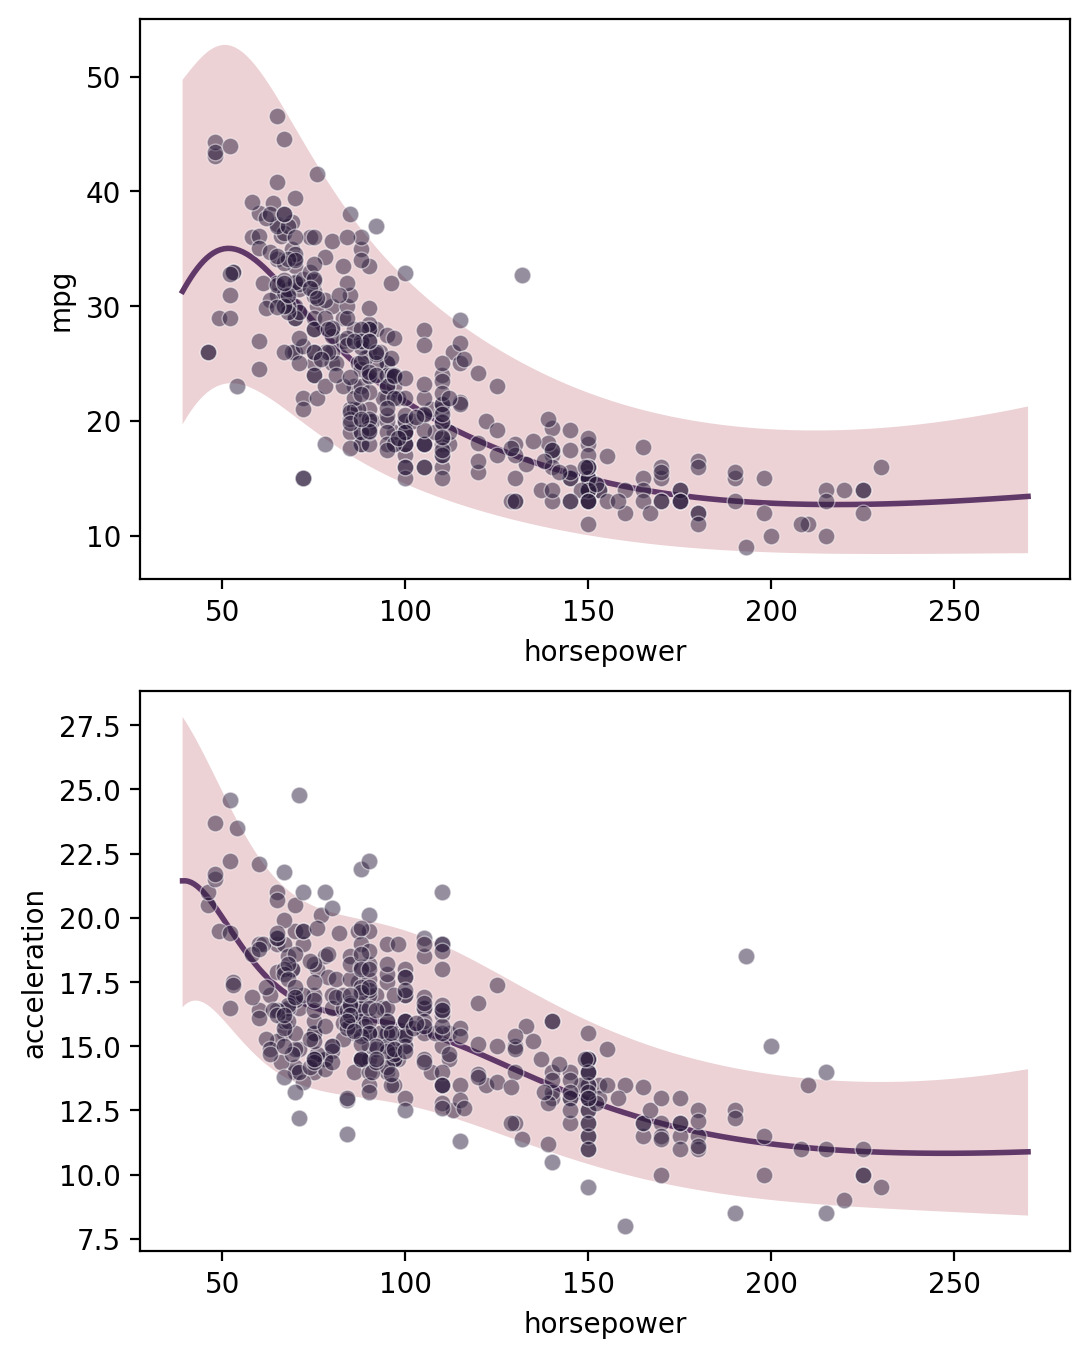

In [5]:
gp = GP(ds)
gp.fit(outputs=['mpg', 'acceleration'], continuous_dims=['horsepower']);

X = gp.prepare_grid()
Y = gp.predict_grid()

axs = plt.subplots(2,1, figsize=(6, 8))[1]
for ax, output in zip(axs, gp.outputs):
    y = Y.get(output)

    gmb.ParrayPlotter(X, y).plot(ax=ax)

    sns.scatterplot(data=cars, x='horsepower', y=output, color=sns.cubehelix_palette()[-1], alpha=0.5, ax=ax);

## Learned correlations between outputs

/home/mambaforge/envs/sbdb-main/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


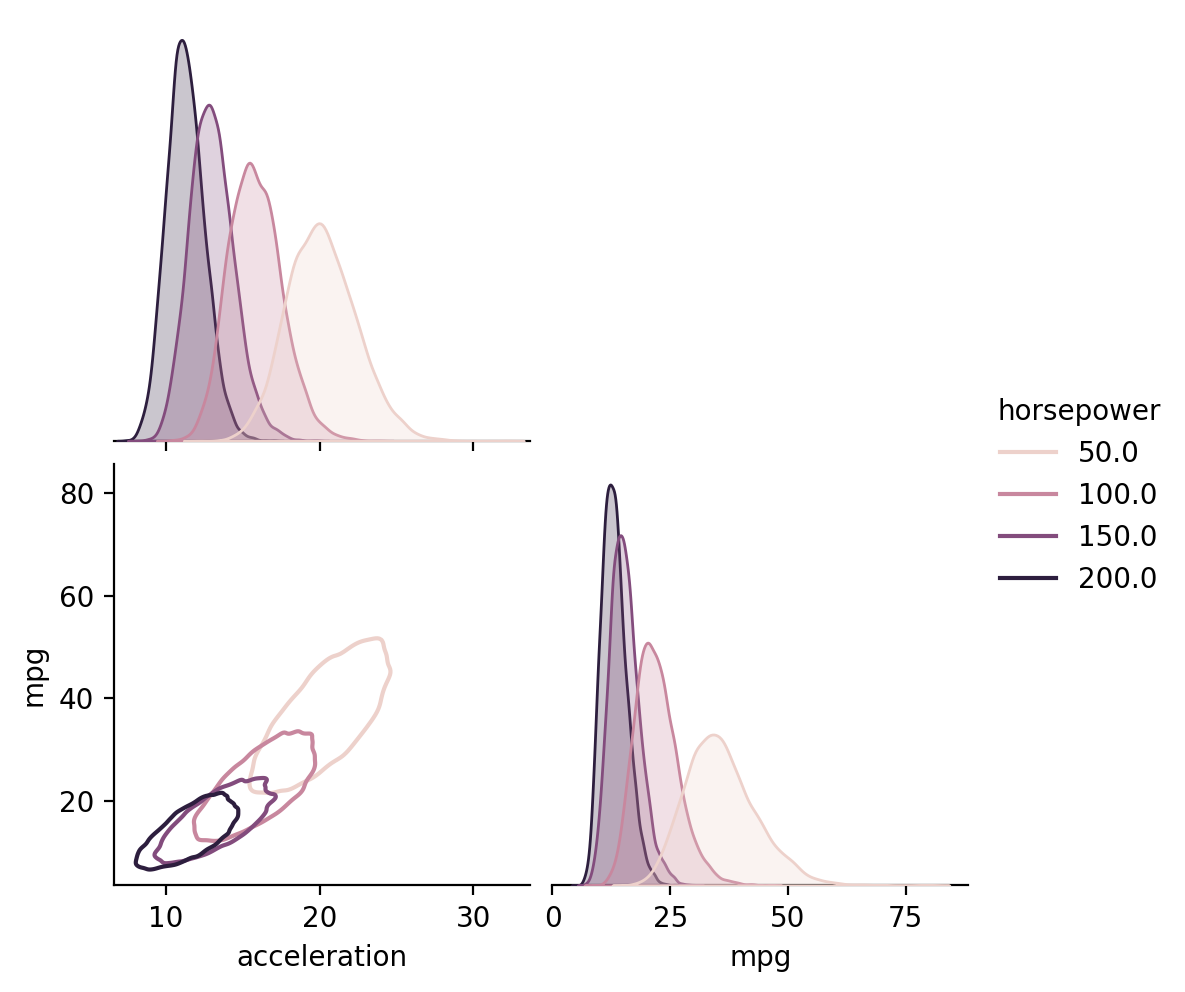

In [8]:
X = gp.parray(horsepower=[50, 100, 150, 200])
gp.predict_points(X)
y = gp.predictions

samples_df = pd.concat(
    [
        pd.DataFrame(point.dist.rvs(10000, random_state=j).as_dict()).assign(
            horsepower=hp.values()
        )
        for j, (point, hp) in enumerate(zip(y, X))
    ],
    ignore_index=True,
)

sns.pairplot(
    samples_df, hue="horsepower", kind="kde", corner=True, plot_kws={"levels": 1}
)

# Mixed categorical-continuous regression

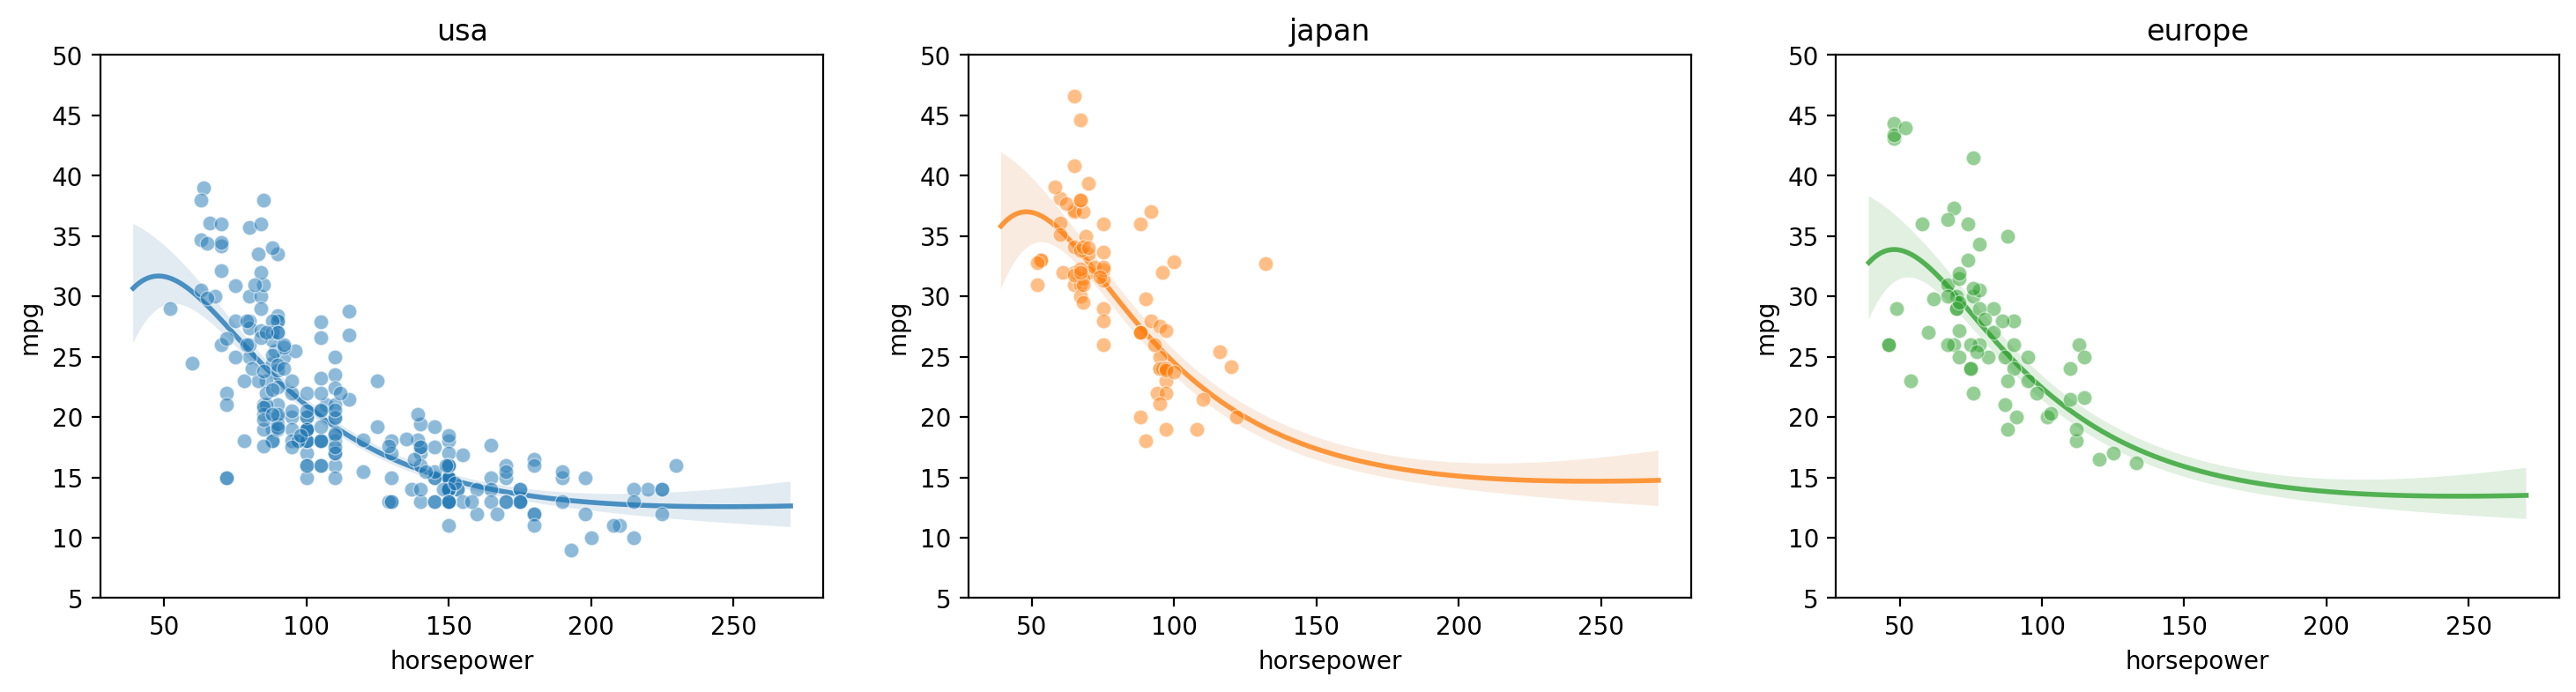

In [9]:
gp = GP(ds)
gp.fit(outputs=['mpg'], categorical_dims=['origin'], continuous_dims=['horsepower']);

X = gp.prepare_grid()
axs = plt.subplots(1,3, figsize=(18, 4))[1]
for i, (ax, origin) in enumerate(zip(axs, cars.origin.unique())):
    y = gp.predict_grid(categorical_levels={'origin': origin}, with_noise=False)

    gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette(f'C{i}'))

    sns.scatterplot(data=cars[cars.origin==origin], x='horsepower', y='mpg', color=f'C{i}', alpha=0.5, ax=ax);
    ax.set_title(origin)
    ax.set_ylim([5, 50])

# Multi-input regression

Here we compare the use of "Automatic Relevance Determination" (ARD) - using independent length scales for each input dimension - to a single length scale for all input dimensions. ARD is on by default in `gumbi` but off by default in `AssayOptimizer` (in which it's controlled by the `isotropic` argument - `True` by default). We can see below that ARD learns that the output changes more rapidly in response to a small change in _horsepower_ relative to _mpg_, as reflected by the more eliptical contours in comparison to the more circular contours of the non-ARD model.

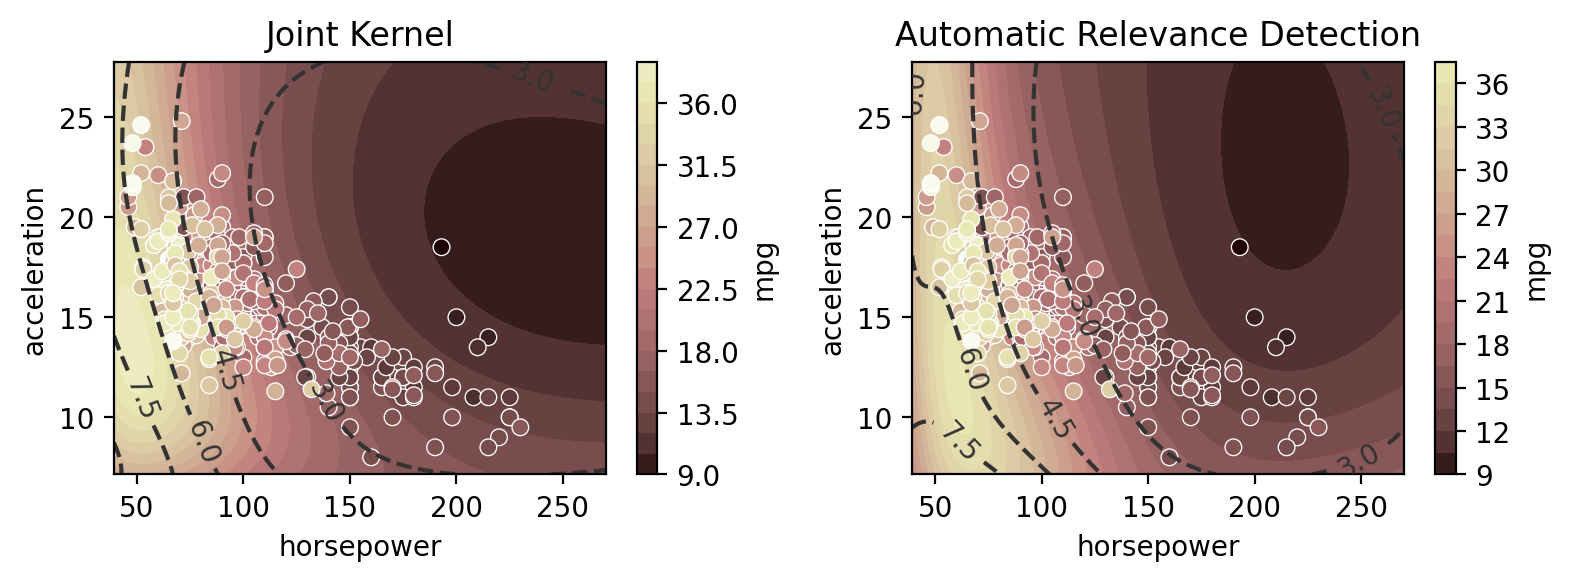

In [15]:
from matplotlib.colors import Normalize as cNormalize
norm = cNormalize()
norm(ds.wide.mpg);

ds3 = gmb.DataSet(
    cars,
    outputs=["mpg"],
    log_vars=["mpg", "acceleration", "weight", "horsepower", "displacement"],
)

gp = GP(ds3)

axs = plt.subplots(1, 2, figsize=(8, 3))[1]
for ax, ard in zip(axs, [False, True]):

    gp.fit(outputs=["mpg"], continuous_dims=["horsepower", "acceleration"], ARD=ard)

    XY = gp.prepare_grid()
    X = XY["horsepower"]
    Y = XY["acceleration"]
    z = gp.predict_grid()
    μ = z.μ
    σ = z.dist.std()

    plt.sca(ax)
    pp = gmb.ParrayPlotter(X, Y, z)
    pp(plt.contourf, levels=20, cmap="pink", norm=norm)
    pp.colorbar(ax=ax)

    cs = ax.contour(
        X.values(), Y.values(), σ, levels=4, colors="0.2", linestyles="--"
    )
    ax.clabel(cs)

    sns.scatterplot(
        data=cars,
        x="horsepower",
        y="acceleration",
        hue="mpg",
        palette="pink",
        hue_norm=norm,
        ax=ax,
    )
    ax.legend().remove()

    title = "Automatic Relevance Detection" if ard else "Joint Kernel"
    ax.set_title(title)

plt.tight_layout()

# Multi-output (Pareto front) optimization with qNEHVI

Finally, Botorch can natively optimize the Pareto front of the multiple objectives. Here we take the toy scenario of wanting to select the ideal weight for a car in order to maximize both its fuel efficiency and horsepower.

There are two methods for specifying the multitask kernel, Hadamard and Kronecker. The Kronecker kernel requires all outputs to be observed at every input, while the Hadamard kernel does not. Practically, the Hadamard kernel may perform better in low output dimensions (it's the default for two or fewer outputs), while the Kronecker kernel supposedly may perform better in higher output dimensions (it's the default for three or more outputs). The choice can be forced by setting the `multitask_kernel` argument to either `"Kronecker"` or `"Hadamard"`.

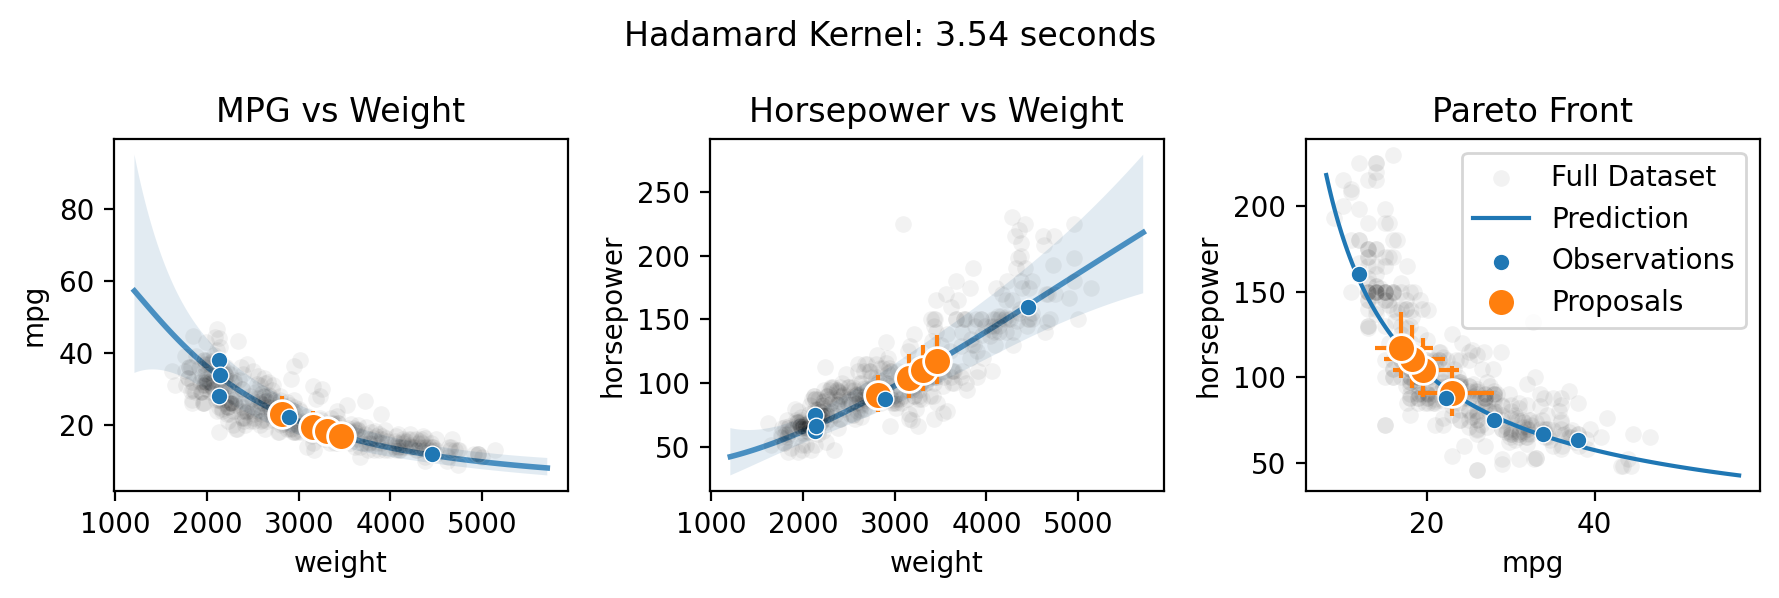

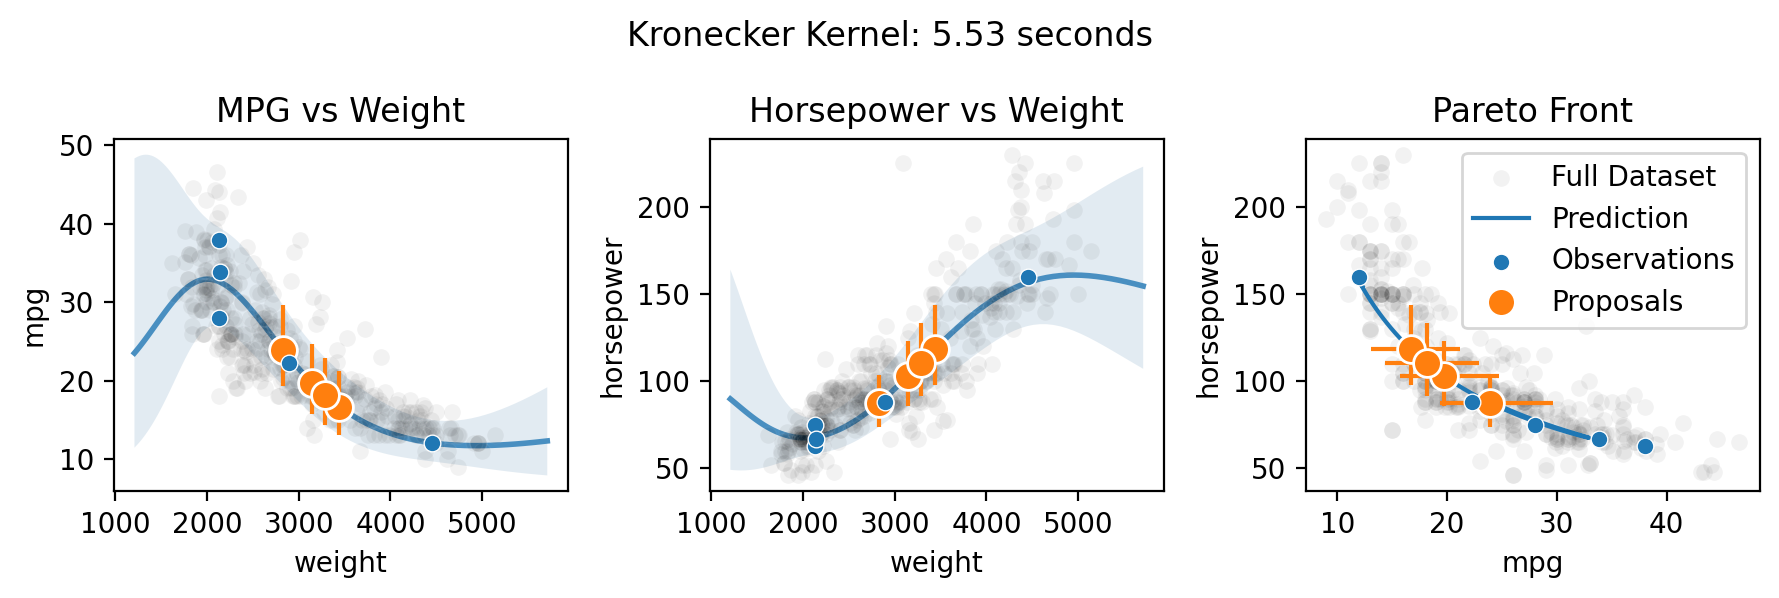

In [12]:
import time
q = 4

ds4 = gmb.DataSet(
    cars.sample(5, random_state=0),
                 outputs=['mpg', 'horsepower','acceleration','displacement','model_year'],
                 log_vars=['mpg', 'acceleration', 'weight', 'horsepower', 'displacement'])

gp = GP(ds4)

for multitask_kernel in ['Hadamard', 'Kronecker']:

    start = time.time()
    gp.fit(outputs=['mpg','horsepower'], continuous_dims=['weight'], continuous_kernel='RBF', seed=0, ARD=True, multitask_kernel=multitask_kernel)

    candidates, _ = gp.propose(q=q)
    preds = gp.predict_points(candidates)

    X = gp.prepare_grid()
    Y = gp.predict_grid()
    end = time.time()

    axs = plt.subplots(1, 3, figsize=(9, 3))[1]
    for ax, output in zip(axs, gp.outputs):
        y = Y.get(output)
        
        sns.scatterplot(data=cars, x='weight', y=output, color='k', alpha=0.05, ax=ax);

        gmb.ParrayPlotter(X, y).plot(ax=ax, palette=sns.light_palette('C0'))
        
        for weight, pred in zip(candidates, preds):
            y = pred.get(output).μ
            y_err = np.abs(np.array([pred.get(output).dist.interval(0.95)]) - y).T
            ax.errorbar(weight, y, y_err, fmt='o', color='C1', ms=10, mec='w')

        sns.scatterplot(data=ds4.wide, x='weight', y=output, color='C0', ax=ax, zorder=10);
        
    ax = axs[2]
    sns.scatterplot(data=cars, x='mpg', y='horsepower', ax=ax, color='k', alpha=0.05, label='Full Dataset')
    ax.plot(Y.get('mpg').μ, Y.get('horsepower').μ, label = 'Prediction', color='C0')

    x = preds.get('mpg').μ
    y = preds.get('horsepower').μ
    x_err = np.abs(np.array(preds.get('mpg').dist.interval(0.95)) - x)
    y_err = np.abs(np.array(preds.get('horsepower').dist.interval(0.95)) - y)
    ax.errorbar(x, y, y_err, x_err, fmt='o', color='C1', ms=10, label='Proposals', mec='w')

    sns.scatterplot(data=ds4.wide, x='mpg', y='horsepower', ax=ax, label='Observations', color='C0', zorder=10)
    ax.legend()

    axs[0].set_title('MPG vs Weight')
    axs[1].set_title('Horsepower vs Weight')
    axs[2].set_title('Pareto Front')
    plt.suptitle(f'{multitask_kernel} Kernel: {end-start:.2f} seconds')
    plt.tight_layout()